In [ ]:
# Install required packages

%pip install -U langgraph langchain_community langchain_openai langsmith langchain_anthropic

In [3]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----


_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("ANTHROPIC_API_KEY")      # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("OPENAI_MODEL")           # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")
_set_if_undefined("ANTHROPIC_MODEL")        # Model name (e.g., "claude-sonnet-4-20250514, claude-3-7-sonnet-latest")



In [ ]:
# Network
# Each agent can communicate with every other agent (many-to-many connections) 
# and can decide which agent to call next.

import sys
import os
from typing import Literal
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
from langchain_anthropic import ChatAnthropic
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

# Load the model name from environment variables
anthropic_model = os.environ["ANTHROPIC_MODEL"]
# Initialize the LLM (Large Language Model) interface
anthropic_llm = ChatAnthropic(model=anthropic_model)


class Router(TypedDict):
    """Next coaches to apply brakes. If all coaches are already braking, route to __end__."""
    next_coaches: list
   
class CoachStatus(TypedDict):
    """coach braking status. If already braking return True otherwise False."""
    braking: Literal[True, False]

system_prompt = (
   "You are a coach attached to a train along with other coaches."
   "There are total 5 coaches including you (coach_1, coach_2, coach_3, coach_4, coach_5). "
   "Instructions: "
   "- Each coach can independently apply brakes upon receiving a command. "
   "- All coaches must apply their brakes simultaneously and individually update their braking status. "
   "Given the following user request, "
   "- Clearly list the coaches that have NOT yet applied brakes and need to act next. "
   f"- If all coaches have already applied brakes, respond with {END}."
)

def coach_1(state: MessagesState) -> Command[Literal["coach_2", "coach_3","coach_4","coach_5", END]]:
    this_coach_name = sys._getframe(  ).f_code.co_name
    return coach_logic(this_coach_name=this_coach_name, state=state)

def coach_2(state: MessagesState) -> Command[Literal["coach_1", "coach_3","coach_4","coach_5", END]]:
    this_coach_name = sys._getframe(  ).f_code.co_name
    return coach_logic(this_coach_name=this_coach_name, state=state)

def coach_3(state: MessagesState) -> Command[Literal["coach_1", "coach_2","coach_4","coach_5", END]]:
    this_coach_name = sys._getframe(  ).f_code.co_name
    return coach_logic(this_coach_name=this_coach_name, state=state)

def coach_4(state: MessagesState) -> Command[Literal["coach_1", "coach_2","coach_3","coach_5", END]]:
    this_coach_name = sys._getframe(  ).f_code.co_name
    return coach_logic(this_coach_name=this_coach_name, state=state)

def coach_5(state: MessagesState) -> Command[Literal["coach_1", "coach_2","coach_3","coach_4", END]]:
    this_coach_name = sys._getframe(  ).f_code.co_name
    return coach_logic(this_coach_name=this_coach_name, state=state)

def coach_logic(this_coach_name: str, state: MessagesState) -> Command[Literal["coach_1", "coach_2", "coach_3","coach_4","coach_5", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_coaches" field)
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"] 
            
    response = anthropic_llm.with_structured_output(Router).invoke(messages)

    # Filter out self from the list
    recipients = [coach for coach in response["next_coaches"] if coach != this_coach_name]

    # check if already initiated brake.
    messages = state["messages"] + [ f"Looking at the messages history, identify if {this_coach_name} is already braking" ]

    coach_staus = anthropic_llm.with_structured_output(CoachStatus).invoke(messages)

    updated_message = "I am already Braking" if coach_staus["braking"] == True else "I am Braking"

    # route to one of the agents or exit based on the LLM's decision
    # if the LLM returns "__end__", the graph will finish execution
    return Command(
        goto=recipients,
        update={
            "messages": [
                HumanMessage(content=updated_message, name=this_coach_name)
            ]
        },
    )




In [10]:
# ---- Define network graph ----

builder = StateGraph(MessagesState)
builder.add_node(coach_1)
builder.add_node(coach_2)
builder.add_node(coach_3)
builder.add_node(coach_4)
builder.add_node(coach_5)

builder.add_edge(START, "coach_2")
network = builder.compile(name="train_network")


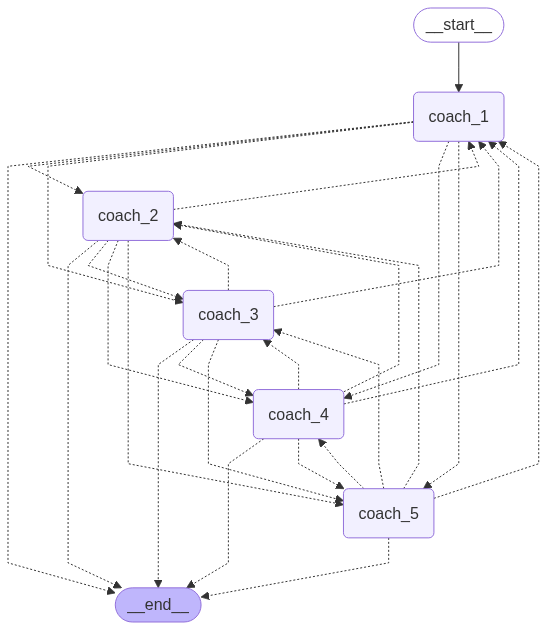

In [8]:
from IPython.display import display, Image
display(Image(network.get_graph().draw_mermaid_png()))

In [11]:
# ---- Stream user input ----

for s in network.stream(
    {"messages": [("user", "Brake")]}, debug=True):
    print(s)
    print("============================")

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user', 'Brake')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'Brake')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Brake', additional_kwargs={}, response_metadata={}, id='328af466-55e3-4758-a739-abcfe393b022')]}
[1:tasks] Starting 1 task for step 1:
- coach_2 -> {'messages': [HumanMessage(content='Brake', additional_kwargs={}, response_metadata={}, id='328af466-55e3-4758-a739-abcfe393b022')]}
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [HumanMessage(content='I am Braking', additional_kwargs={}, response_metadata={}, name='coach_2')]
[1:checkpoint] State at the end of step 1:
{'messages': [HumanMessage(content='Brake', additional_kwargs={}, response_metadata={}, id='328af466-55e3-4758-a739-abcfe393b022'),
              HumanMessage(content='I am Braking', additional_k